In [11]:
#pre requirements
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow==2.5.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.5.0


In [12]:
!nvidia-smi

Mon Dec 11 00:06:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150         WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0              N/A / ERR! |    121MiB /  2048MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [13]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [14]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [15]:
tf.config.list_physical_devices('GPU')

[]

### Load data into tf dataset

In [16]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 30000 files belonging to 11 classes.


### Check information

In [18]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy',
 'no_leaf']

In [19]:
len(dataset)

469

In [20]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch.numpy())

#(batch_size, H, V, Channel)

(64, 256, 256, 3)
[[[[139.        122.        138.       ]
   [135.67969   118.67969   134.67969  ]
   [129.26562   112.265625  128.26562  ]
   ...
   [136.2832    125.2832    141.2832   ]
   [137.16992   126.16992   142.16992  ]
   [138.        127.        143.       ]]

  [[134.01953   117.01953   133.01953  ]
   [132.76631   115.76631   131.76631  ]
   [129.15538   112.15538   128.15538  ]
   ...
   [133.79297   122.79297   138.79297  ]
   [134.67969   123.67969   139.67969  ]
   [135.50977   124.509766  140.50977  ]]

  [[133.7168    116.7168    132.7168   ]
   [134.6717    117.67171   133.6717   ]
   [133.5414    116.5414    132.5414   ]
   ...
   [128.26562   117.265625  133.26562  ]
   [129.15234   118.15234   134.15234  ]
   [129.98242   118.98242   134.98242  ]]

  ...

  [[133.        113.        125.       ]
   [139.64062   119.640625  131.64062  ]
   [135.26562   115.265625  127.265625 ]
   ...
   [130.67395   116.67395   129.67395  ]
   [151.67969   137.67969   150.92328  

## Visualize some of the images from our dataset

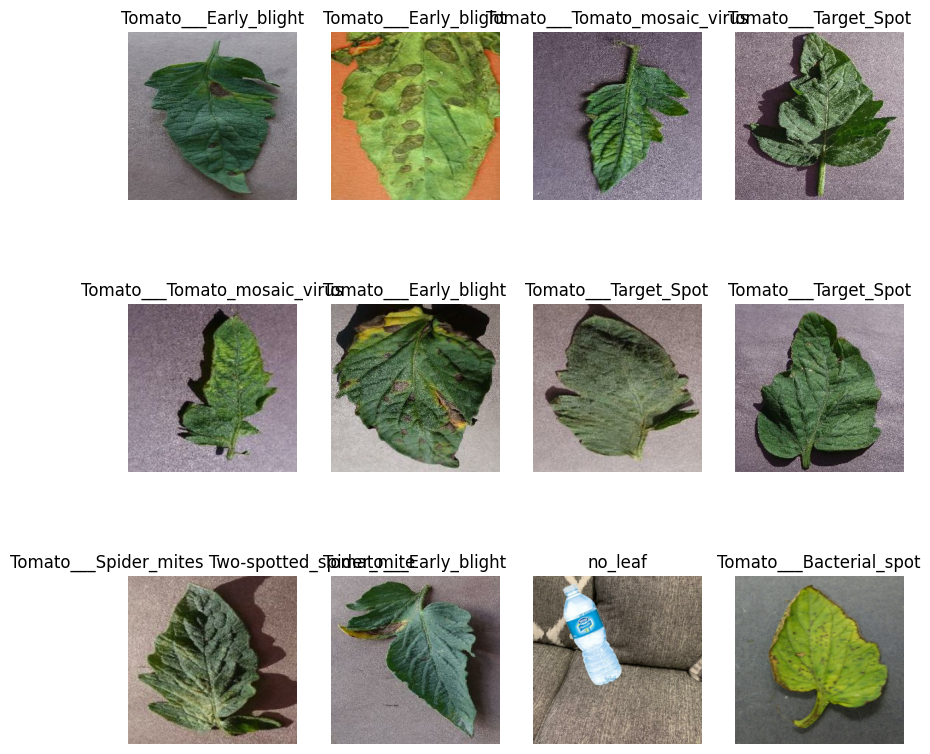

In [21]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model


In [22]:
train_size = 0.8
len(dataset)*train_size

375.20000000000005

In [23]:
train_ds = dataset.take(54)
len(train_ds)

54

In [24]:
test_ds = dataset.skip(54)
len(test_ds)

415

In [25]:
val_size=0.1
len(dataset)*val_size

46.900000000000006

In [26]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [27]:
test_ds = test_ds.skip(6)
len(test_ds)

409

In [28]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:
len(train_ds)


375

In [31]:
len(val_ds)


46

In [32]:
len(test_ds)


48

## Cache, Shuffle, and Prefetch the Dataset

In [33]:
train_ds = train_ds.cache().shuffle(3000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(3000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(3000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model
### Creating a Layer for Resizing and Normalization

In [34]:
##resize and rescale image
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [35]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [36]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [37]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 11

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Add Dropout after the convolutional layers
    layers.Dropout(0.1),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.1),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),

    layers.Dropout(0.1),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (64, 62, 62, 64)         

## Compiling the Model

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
375/375 [==============================] - 2820s 6s/step - loss: 1.9805 - accuracy: 0.2775 - val_loss: 1.5799 - val_accuracy: 0.4273
Epoch 2/20
375/375 [==============================] - 2898s 8s/step - loss: 1.3279 - accuracy: 0.5411 - val_loss: 1.0546 - val_accuracy: 0.6338
Epoch 3/20
375/375 [==============================] - 3492s 9s/step - loss: 0.9908 - accuracy: 0.6614 - val_loss: 0.8204 - val_accuracy: 0.7133
Epoch 4/20
375/375 [==============================] - 6019s 16s/step - loss: 0.8145 - accuracy: 0.7203 - val_loss: 0.7088 - val_accuracy: 0.7510
Epoch 5/20
375/375 [==============================] - 6145s 16s/step - loss: 0.7220 - accuracy: 0.7512 - val_loss: 0.6838 - val_accuracy: 0.7592
Epoch 6/20
375/375 [==============================] - 6461s 17s/step - loss: 0.6428 - accuracy: 0.7771 - val_loss: 0.6065 - val_accuracy: 0.7840
Epoch 7/20
375/375 [==============================] - 6050s 16s/step - loss: 0.5867 - accuracy: 0.7981 - val_loss: 0.6899 - val_accur

In [41]:
scores = model.evaluate(test_ds)

48/48 [==============================] - 773s 2s/step - loss: 0.2692 - accuracy: 0.9053


In [42]:
scores

[0.2691819965839386, 0.9052734375]

In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 375}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
type(history.history['loss'])

list

In [47]:
len(history.history['loss'])

20

In [48]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.9804548025131226,
 1.3279465436935425,
 0.9907504916191101,
 0.8144561648368835,
 0.7220260500907898]

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

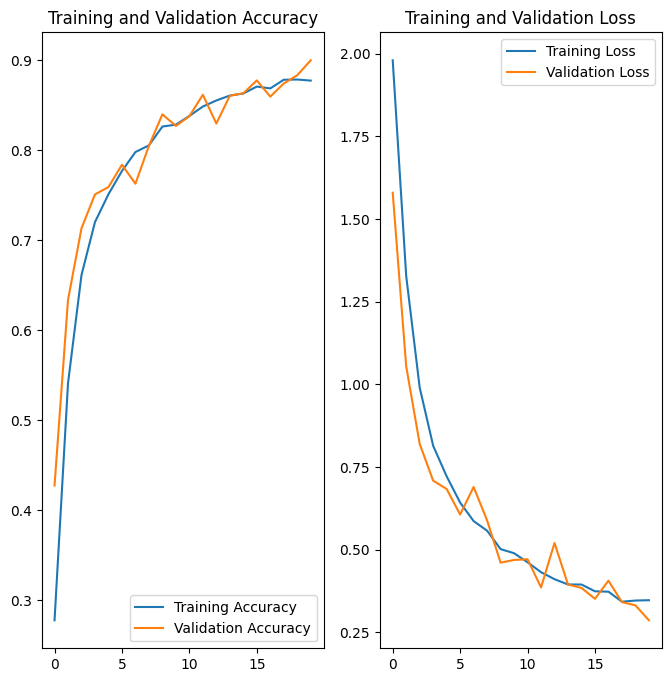

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Tomato___Leaf_Mold
2/2 [==============================] - 2s 632ms/step
predicted label: Tomato___Leaf_Mold


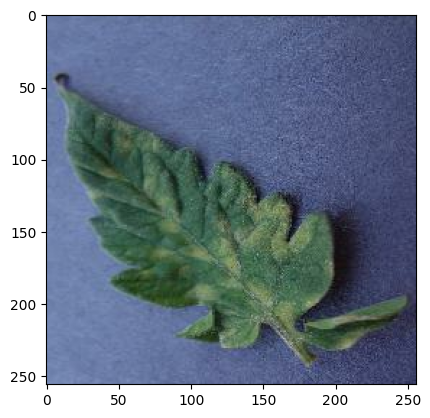

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Now run inference on few sample images

1/1 [==============================] - 0s 71ms/step


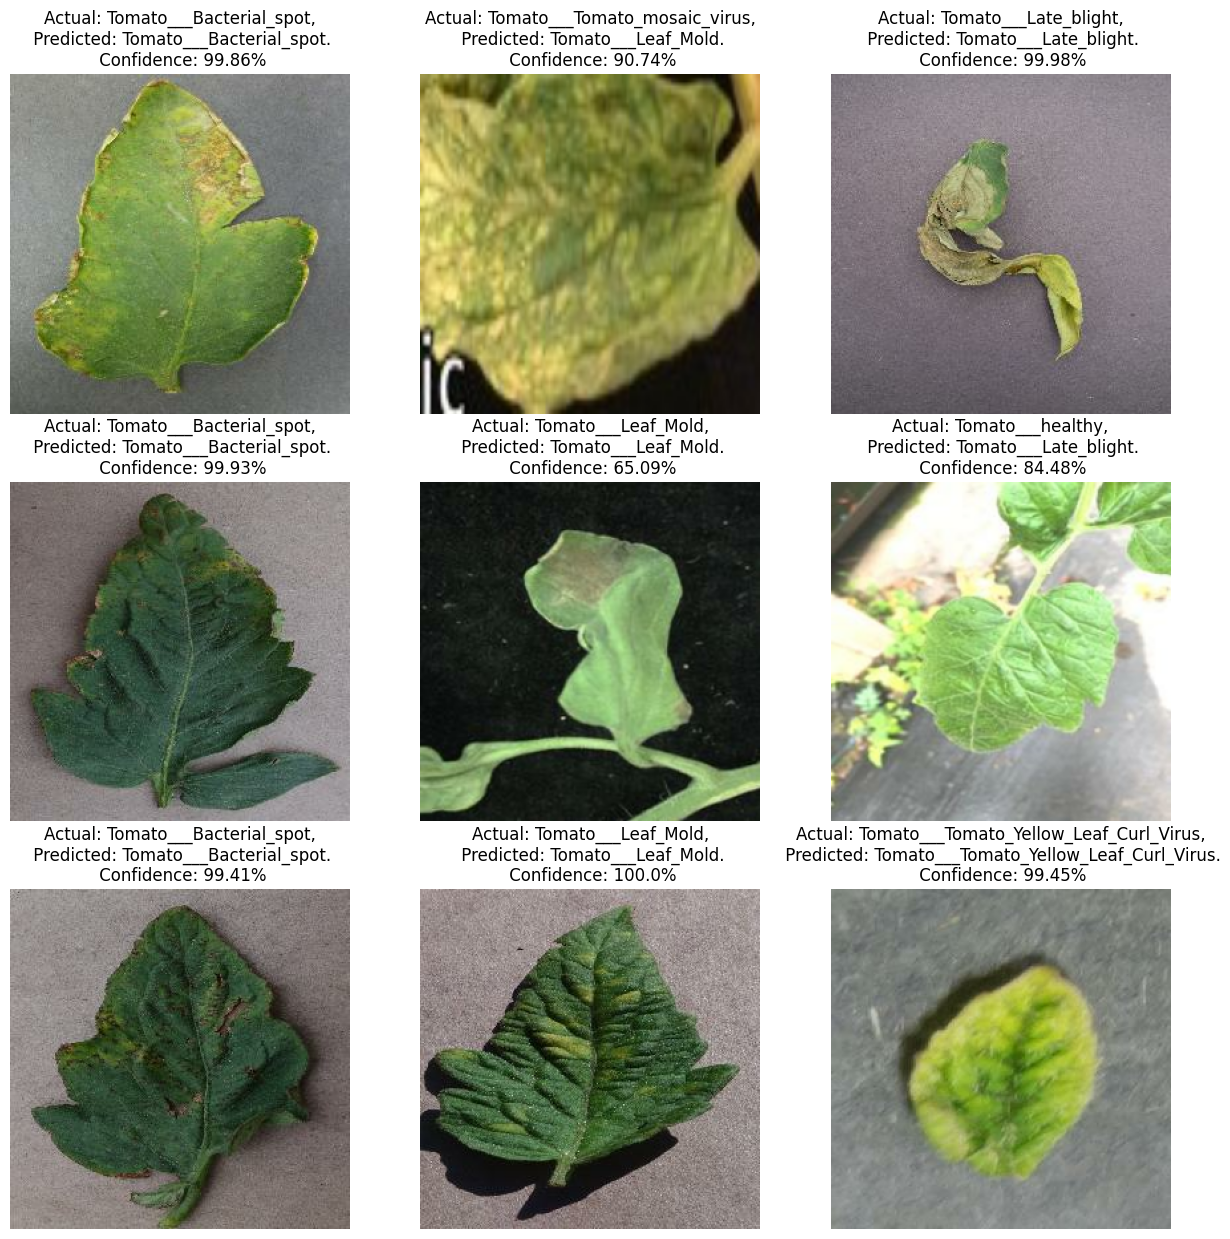

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

confusionMatrix

In [54]:
import numpy as np

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    # Get model predictions for the batch
    batch_predictions = model.predict(images_batch)
    
    # Convert predictions to class labels
    predicted_classes = np.argmax(batch_predictions, axis=1)
    
    # Append true and predicted labels to the lists
    true_labels.extend(labels_batch.numpy())
    predicted_labels.extend(predicted_classes)


2/2 [==============================] - 1s 626ms/step


In [ ]:
model.save("tomato3w.h5")

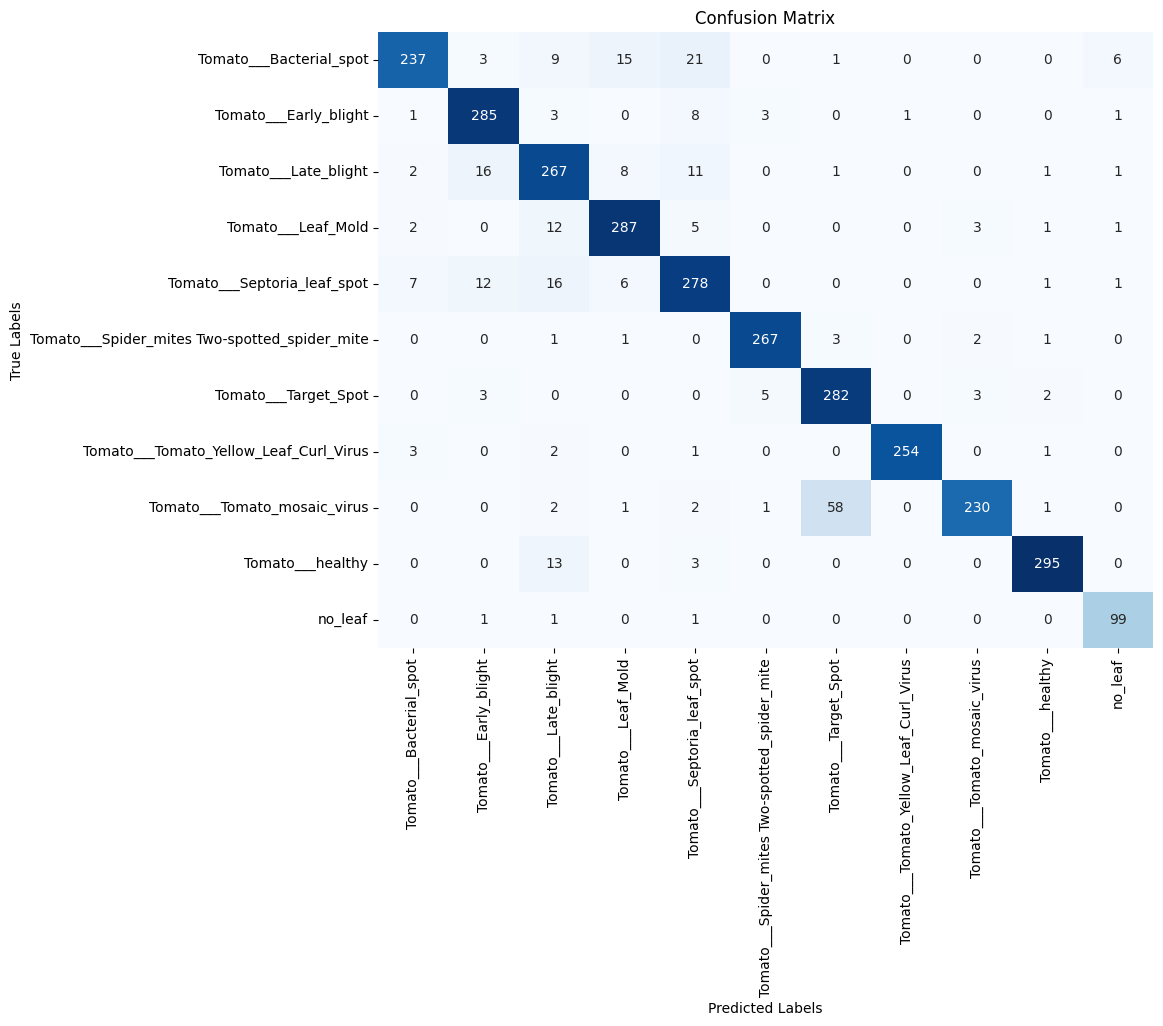

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a DataFrame for visualization
conf_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


precision, recall, and F1-score

In [56]:
from sklearn.metrics import classification_report

test_images, test_labels = [], []
for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)



In [57]:
# Predict on the test set
predictions = model.predict(test_images)

# Convert predicted probabilities to class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Convert tensor to numpy array for classification report
true_labels = test_labels.numpy()
predicted_labels = predicted_labels.numpy()

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

96/96 [==============================] - 58s 605ms/step
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.94      0.81      0.87       292
                        Tomato___Early_blight       0.89      0.94      0.92       302
                         Tomato___Late_blight       0.82      0.87      0.84       307
                           Tomato___Leaf_Mold       0.90      0.92      0.91       311
                  Tomato___Septoria_leaf_spot       0.84      0.87      0.85       321
Tomato___Spider_mites Two-spotted_spider_mite       0.97      0.97      0.97       275
                         Tomato___Target_Spot       0.82      0.96      0.88       295
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.97      0.98       261
                 Tomato___Tomato_mosaic_virus       0.97      0.78      0.86       295
                             Tomato___healthy       0.97      0.95      0

## Saving the Model

In [58]:
model.save("tomato3w.h5")

C:\Users\fuyua\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
